In [453]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [454]:
# Random seed
np.random.seed(42)
torch.manual_seed(42)

In [455]:
# Load data
df = pd.read_csv('../data/BMED_data_v6.csv')

In [456]:
# Initialize scalers
scaler_feature = StandardScaler()
columns_to_scale = [col for col in df.columns if col not in ['exp', 't']]
scaled_data = scaler_feature.fit_transform(df[columns_to_scale])
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
scaled_df['exp'] = df['exp']
scaled_df['t'] = df['t']
scaled_df

,T,V,E,Ki,CF_LA,CA_LA,VF,VA,exp,t
0,1.060632,-0.983713,0.0,-0.976385,-0.734957,-0.944626,0.075929,-0.225989,1,0.0
1,1.060632,-0.983713,0.0,-0.976385,-0.766472,-0.890333,0.209516,-0.332337,1,1.0
2,1.060632,-0.983713,0.0,-0.976385,-0.797756,-0.806806,0.209516,-0.332337,1,2.0
3,1.060632,-0.983713,0.0,-0.976385,-0.836057,-0.657948,-0.057659,-0.225989,1,3.0
4,1.060632,-0.983713,0.0,-0.976385,-0.941527,-0.347703,-0.391627,-0.119641,1,4.0
...,...,...,...,...,...,...,...,...,...,...
131,-0.857341,-0.983713,0.0,-0.477181,-0.332399,-0.666300,0.543485,-0.545033,22,2.0
132,-0.857341,-0.983713,0.0,-0.477181,-0.464438,-0.401996,0.944247,-0.970425,22,4.0
133,-0.857341,-0.983713,0.0,-0.477181,-0.495953,-0.302658,0.944247,-0.970425,22,5.0
134,-0.857341,-0.983713,0.0,-0.477181,-0.536899,-0.108755,0.743866,-0.970425,22,6.0


In [457]:
# Split the data by experiment number
dict_spline = {}
for exp in scaled_df['exp'].unique():
    dict_spline[exp] = scaled_df[scaled_df['exp'] == exp].sort_values('t')
display(dict_spline)

{np.int64(1):           T         V    E        Ki     CF_LA     CA_LA        VF        VA  \
 0  1.060632 -0.983713  0.0 -0.976385 -0.734957 -0.944626  0.075929 -0.225989   
 1  1.060632 -0.983713  0.0 -0.976385 -0.766472 -0.890333  0.209516 -0.332337   
 2  1.060632 -0.983713  0.0 -0.976385 -0.797756 -0.806806  0.209516 -0.332337   
 3  1.060632 -0.983713  0.0 -0.976385 -0.836057 -0.657948 -0.057659 -0.225989   
 4  1.060632 -0.983713  0.0 -0.976385 -0.941527 -0.347703 -0.391627 -0.119641   
 5  1.060632 -0.983713  0.0 -0.976385 -1.168685  0.236989 -0.525215 -0.438685   
 
    exp    t  
 0    1  0.0  
 1    1  1.0  
 2    1  2.0  
 3    1  3.0  
 4    1  4.0  
 5    1  5.1  ,
 np.int64(2):            T         V    E        Ki     CF_LA     CA_LA        VF        VA  \
 6   0.455794 -0.983713  0.0 -0.976385 -0.734957 -0.944626  0.075929 -0.225989   
 7   0.455794 -0.983713  0.0 -0.976385 -0.767967 -0.887052  0.209516 -0.225989   
 8   0.455794 -0.983713  0.0 -0.976385 -0.892760 -0.5

In [458]:
# Feedforward network for migration prediction
class MigrationPredictor(nn.Module):
    def __init__(self, input_node = 6, hidden_nodes = 64, hidden_layers = 3, output_nodes = 3):
        super().__init__()
        
        # Layer configuration
        layers = []
        # input layer
        layers.append(nn.Linear(input_node, hidden_nodes))
        layers.append(nn.ReLU())

        # hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_nodes, hidden_nodes))
            layers.append(nn.ReLU())

        # output layer
        layers.append(nn.Linear(hidden_nodes, output_nodes))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        selected_features = x[:, :6] if len(x.shape) > 1 else x[:6]
        return self.model(selected_features)

In [459]:
# Physical Layers for State update
class PhysicalLayer:
    def __init__(self, dt = 0.1):
        self.dt = dt
    
    def update_state(self, cur_state, migration):
        # Current States
        T = cur_state[0]
        V = cur_state[1]
        E = cur_state[2]
        Ki = cur_state[3]
        CF_LA = cur_state[4]
        CA_LA = cur_state[5]
        VF = cur_state[6]
        VA = cur_state[7]
        
        # Migration
        dNLA = migration[0] * self.dt
        dVF = migration[1] * self.dt
        dVA = migration[2] * self.dt

        # Fixed variables
        nT = T
        nV = V
        nE = E
        nKi = Ki       
        
        # New Volumes
        nVF = VF + dVF
        nVA = VA + dVA

        # New Concentrations
        nCF_LA = (CF_LA * VF - dNLA) / nVF
        nCA_LA = (CA_LA * VA - dNLA) / nVA

        # New States
        new_state = cur_state.clone()
        new_state[0] = nT
        new_state[1] = nV
        new_state[2] = nE
        new_state[3] = nKi
        new_state[4] = nCF_LA
        new_state[5] = nCA_LA
        new_state[6] = nVF
        new_state[7] = nVA
        
        return new_state

In [460]:
class BMEDDataset(Dataset):
    def __init__(self, dict_spline):
        self.features = ['T', 'V', 'E', 'Ki', 'CF_LA', 'CA_LA', 'VF', 'VA']
        self.experiments = []

        for exp_id, exp_data in dict_spline.items():
            # Save whole data of each experiment in one sample
            exp_array = exp_data[self.features].values
            times = exp_data['t'].values
            self.experiments.append({
                'init_state': exp_array[0], # initial state
                'measured_state': exp_array, # whole measurements
                'times': times # time points
            })
    
    def __len__(self):
        return len(self.experiments)
    
    def __getitem__(self, idx):
        return self.experiments[idx]

In [461]:
class BMEDModel(nn.Module):
    def __init__(self, input_node = 6, hidden_nodes = 32, hidden_layers = 3, output_nodes = 3, dt = 0.1):
        super().__init__()
        self.migration_predictor = MigrationPredictor(input_node, hidden_nodes, hidden_layers, output_nodes)
        self.physical_layer = PhysicalLayer(dt)
        self.dt = dt

    def forward(self, init_state, measured_time):
        '''
        initial_state: initial state of the experiment (batch_size, 8)
        measured_time: time points of the measurements (batch_size, n_measurements)
        '''
        # 배치 처리를 위한 초기화
        batch_size = init_state.shape[0]
        device = init_state.device
        
        # 각 배치에 대한 결과를 저장할 리스트
        all_pred_states = []
        all_measured_indices = []

        for b in range(batch_size):
            cur_state = init_state[b]  # (8,)
            cur_time = 0.0
            pred_states = []
            measured_indices = []

            # 현재 배치의 측정 시간들
            times = measured_time[b]  # (n_measurements,)
            max_time = times[-1].item()  # 스칼라 값으로 변환

            # 초기 상태 저장
            pred_states.append(cur_state.unsqueeze(0))  # (1, 8)

            while cur_time < max_time:
                # 상태 예측
                migration = self.migration_predictor(cur_state.unsqueeze(0))  # (1, 6) -> (1, 3)
                cur_state = self.physical_layer.update_state(cur_state, migration[0])  # (8,)
                pred_states.append(cur_state.unsqueeze(0))  # (1, 8)
                cur_time += self.dt

                # 측정 시간과 매칭
                for i, t in enumerate(times):
                    if abs(cur_time - t.item()) < self.dt/2:
                        measured_indices.append(len(pred_states) - 1)

            # 현재 배치의 예측 상태들을 스택
            pred_states = torch.cat(pred_states, dim=0)  # (n_steps, 8)
            
            all_pred_states.append(pred_states)
            all_measured_indices.append(measured_indices)

        # 가장 긴 시퀀스에 맞춰 패딩
        max_length = max(states.shape[0] for states in all_pred_states)
        padded_pred_states = []
        
        for states in all_pred_states:
            if states.shape[0] < max_length:
                padding = torch.zeros(max_length - states.shape[0], 8, device=device)
                states = torch.cat([states, padding], dim=0)
            padded_pred_states.append(states.unsqueeze(0))

        # 배치 차원으로 결합
        pred_states_batch = torch.cat(padded_pred_states, dim=0)  # (batch_size, max_length, 8)

        return pred_states_batch, all_measured_indices

In [462]:
def custom_loss(pred_states_batch, measured_indices_batch, measured_states_batch):
    '''
    pred_states_batch: (batch_size, max_length, 8)
    measured_states_batch: (batch_size, n_measurements, 8)
    measured_indices_batch: list of lists containing indices
    '''
    batch_size = pred_states_batch.shape[0]
    total_loss = 0

    for b in range(batch_size):
        pred_states = pred_states_batch[b]  # (max_length, 8)
        measured_states = measured_states_batch[b]  # (n_measurements, 8)
        indices = measured_indices_batch[b]

        for idx, measured_state in zip(indices, measured_states):
            predicted_state = pred_states[idx]
            total_loss += torch.mean((predicted_state - measured_state) ** 2)

    return total_loss / batch_size

In [463]:
def train_model(model, train_loader, num_epochs = 100, learning_rate = 0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            init_state = batch['init_state'].float().to(device)
            measured_state = batch['measured_state'].float().to(device)
            times = batch['times'].float().to(device)

            # Simulation
            pred_state, measured_indices = model(init_state, times)

            # Loss
            loss = custom_loss(pred_state, measured_indices, measured_state)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

In [464]:
# set data loader
dataset = BMEDDataset(dict_spline)
train_loader = DataLoader(dataset, batch_size = 1, shuffle = True)


In [465]:
# train model
model = BMEDModel(input_node = 6, hidden_nodes = 32, hidden_layers = 3, output_nodes = 3, dt = 0.1)
train_model(model, train_loader)

Epoch 10/100, Loss: 2.5973
Epoch 20/100, Loss: 1.4069
Epoch 30/100, Loss: 4.2848
Epoch 40/100, Loss: 1.1951
Epoch 50/100, Loss: 3.1424
Epoch 60/100, Loss: 11.2216
Epoch 70/100, Loss: 1.5063
Epoch 80/100, Loss: 1.8614
Epoch 90/100, Loss: 1.7508
Epoch 100/100, Loss: 4.2541


In [466]:
import matplotlib.pyplot as plt
import numpy as np

def simulate_and_plot(model, dataset, exp_idx=0):
    """
    학습된 모델을 사용하여 시뮬레이션을 수행하고 결과를 시각화합니다.
    """
    model.eval()  # 평가 모드로 설정
    device = next(model.parameters()).device
    
    # 데이터 준비
    data = dataset[exp_idx]
    init_state = torch.tensor(data['init_state'], dtype=torch.float32).unsqueeze(0).to(device)
    times = torch.tensor(data['times'], dtype=torch.float32).unsqueeze(0).to(device)
    measured_states = torch.tensor(data['measured_state'], dtype=torch.float32).to(device)
    
    # 시뮬레이션 수행
    with torch.no_grad():
        pred_states, measured_indices = model(init_state, times)
        pred_states = pred_states[0].cpu().numpy()  # 배치 차원 제거
    
    # 측정 데이터 준비
    measured_times = data['times']
    measured_states = measured_states.cpu().numpy()
    
    # 시각화
    variables = ['T', 'V', 'E', 'Ki', 'CF_LA', 'CA_LA', 'VF', 'VA']
    fig, axes = plt.subplots(4, 2, figsize=(15, 20))
    axes = axes.flatten()
    
    # 시뮬레이션 시간 포인트 생성 - 길이 맞추기
    sim_times = np.linspace(0, measured_times[-1], len(pred_states))
    
    print(f"시뮬레이션 시간 배열 크기: {sim_times.shape}")
    print(f"예측 상태 배열 크기: {pred_states.shape}")
    
    for i, (ax, var) in enumerate(zip(axes, variables)):
        # 예측값 플롯 - 데이터 크기 확인 후 그리기
        ax.plot(sim_times, pred_states[:, i], 'b-', label='예측값')
        
        # 측정값 플롯
        ax.scatter(measured_times, measured_states[:, i], c='r', marker='o', label='측정값')
        
        ax.set_title(f'{var} vs Time')
        ax.set_xlabel('Time')
        ax.set_ylabel(var)
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

시뮬레이션 시간 배열 크기: (41,)
예측 상태 배열 크기: (41, 8)


C:\Users\bsjun\AppData\Local\Temp\ipykernel_31520\1875905617.py:50: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsjun\AppData\Local\Temp\ipykernel_31520\1875905617.py:50: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsjun\AppData\Local\Temp\ipykernel_31520\1875905617.py:50: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsjun\AppData\Local\Temp\ipykernel_31520\1875905617.py:50: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


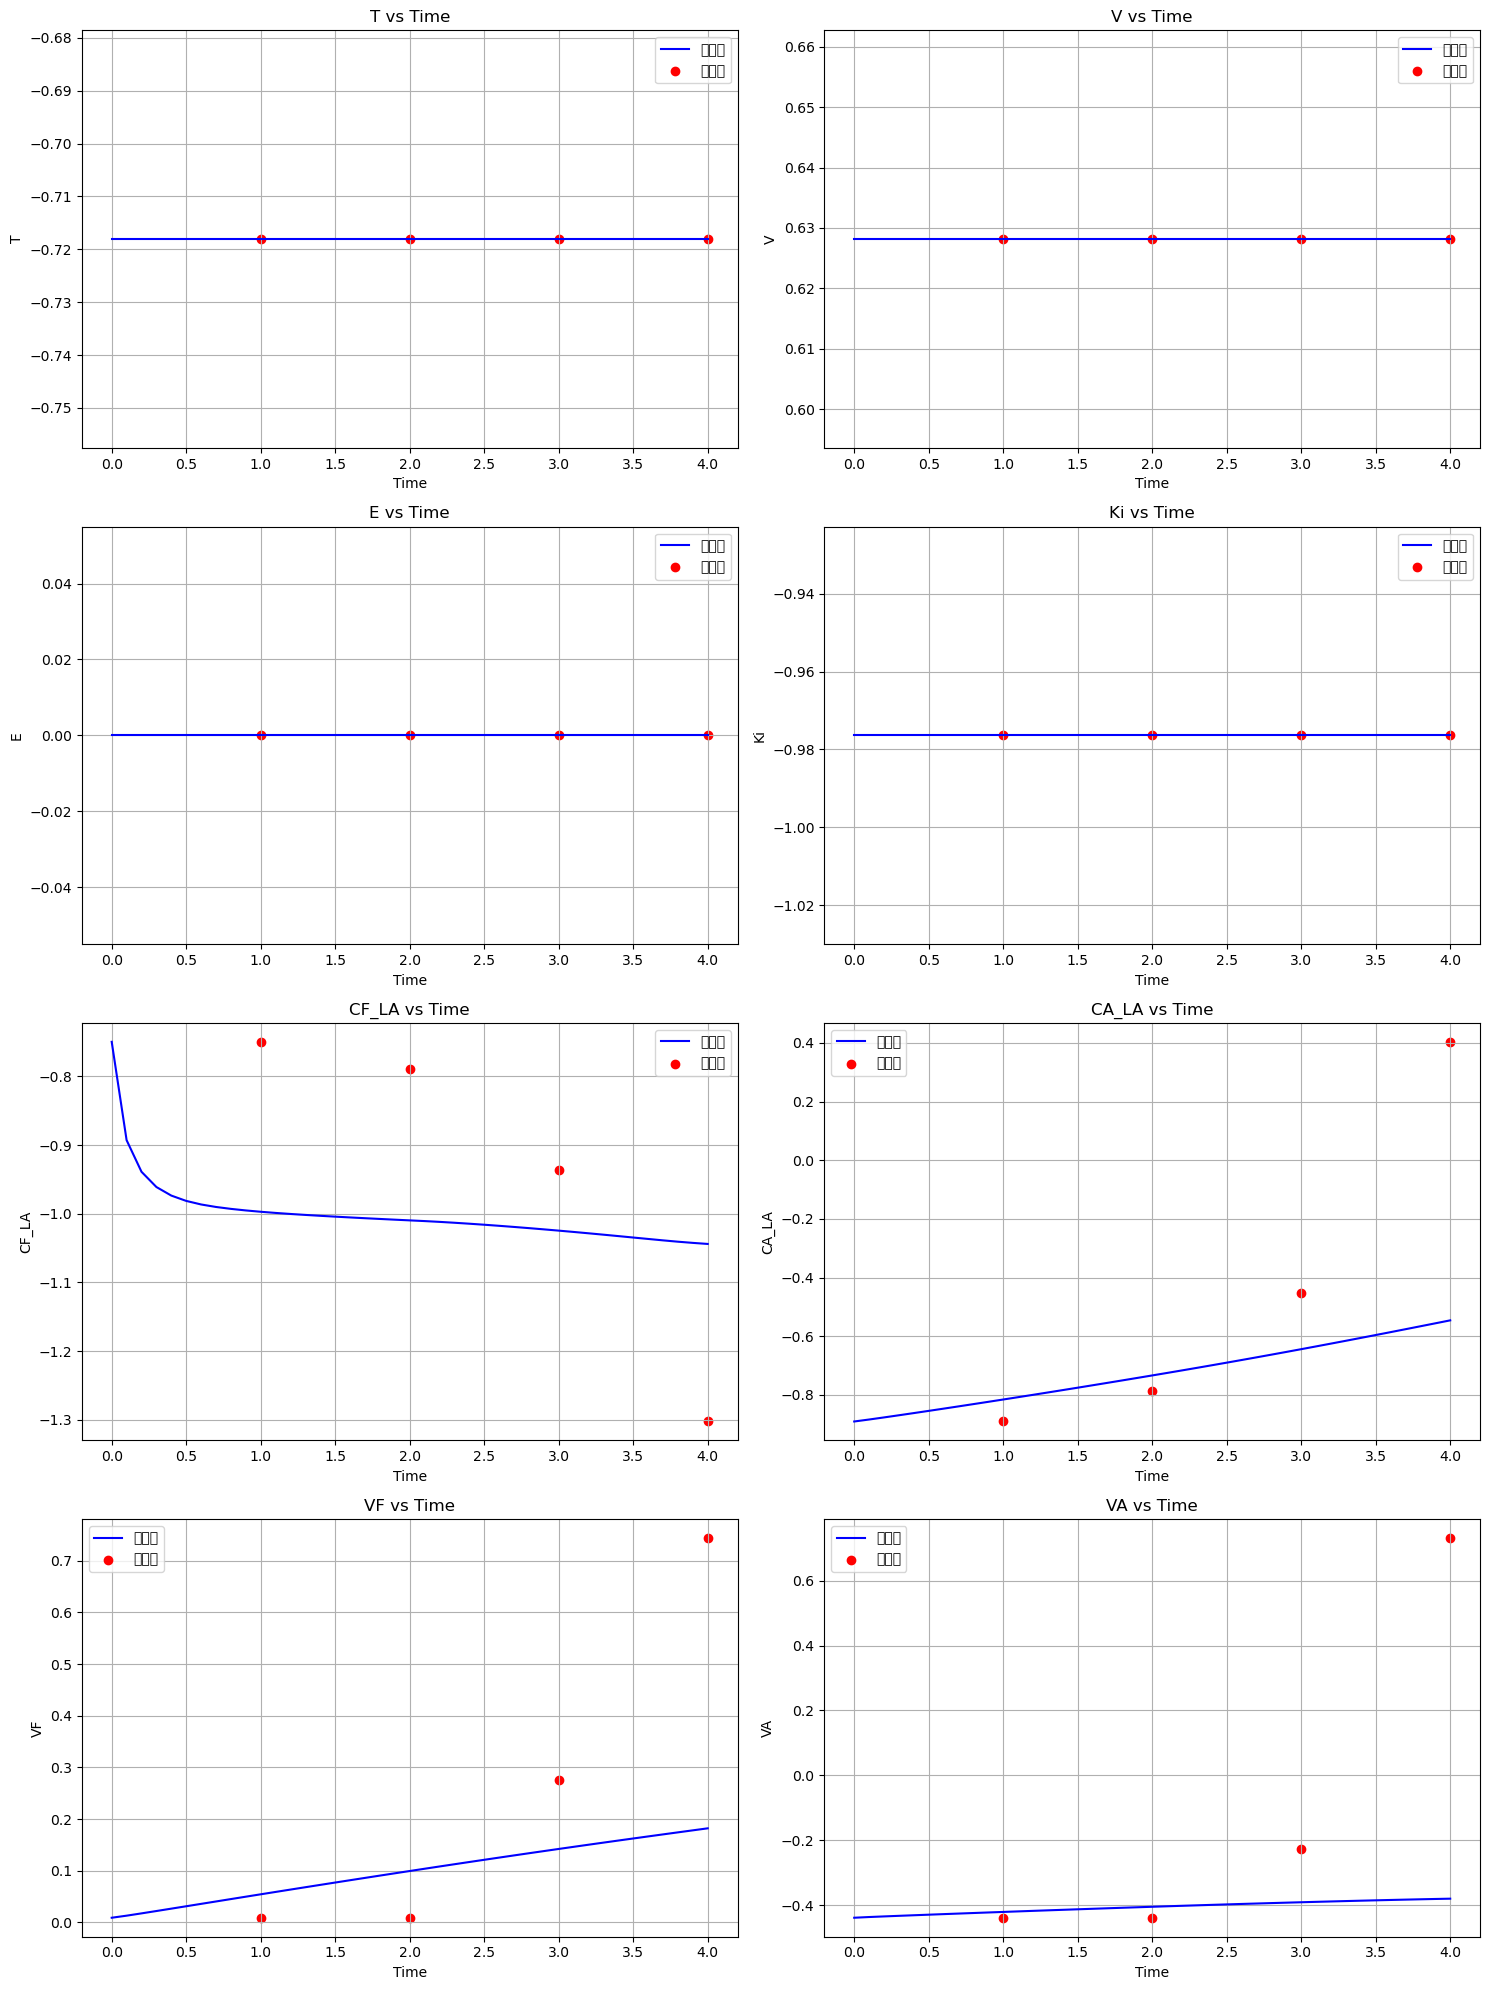

In [468]:
simulate_and_plot(model,dataset,exp_idx=5)